In [1]:
!pip install py_ecc matplotlib numpy scipy

  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp313-cp313-win_amd64.whl.metadata (6.9 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
Using cached pydantic-2.11.7-py3-none-any.whl (444 kB)
Using cached pydantic_core-2.33.2-cp313-cp313-win_amd64.whl (2.0 MB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached typing_inspection-0.4.1-py3-none-any.whl (14 kB)

   ------------ ---------------------------  3/10 [eth-typing]
   ------------------------ ---------------  6/10 [pydantic]
   ------------------------ ---------------  6/10 [pydantic]
   ---------------------------- -----------  7/10 [cytoolz]
   ------------------------------------ ---  9/10 [py_ecc]
   ---------------------------------------- 10/10 [py_ecc]



Could not find platform independent libraries <prefix>


--- Testing BPO-Test Demonstration Function ---
Collinear Test Result (CP): 0 (Expected: 0)
Left Turn Test Result (CP): 4 (Expected: > 0)
Right Turn Test Result (CP): -4 (Expected: < 0)
Collinear Test 2 Result (CP): 0 (Expected: 0)
Negative Coords Test Result (CP): -2 (Expected: < 0)

--- BPO-Test Demonstration Tests Passed! ---

--- Running PBMC-CH with 20 points ---
PBMC-CH computation time: 56.4138 seconds
Computed Convex Hull Points (7 points):
Point(x=-49, y=1)
Point(x=-48, y=-44)
Point(x=-17, y=-46)
Point(x=39, y=-38)
Point(x=49, y=49)
Point(x=17, y=45)
Point(x=-46, y=10)


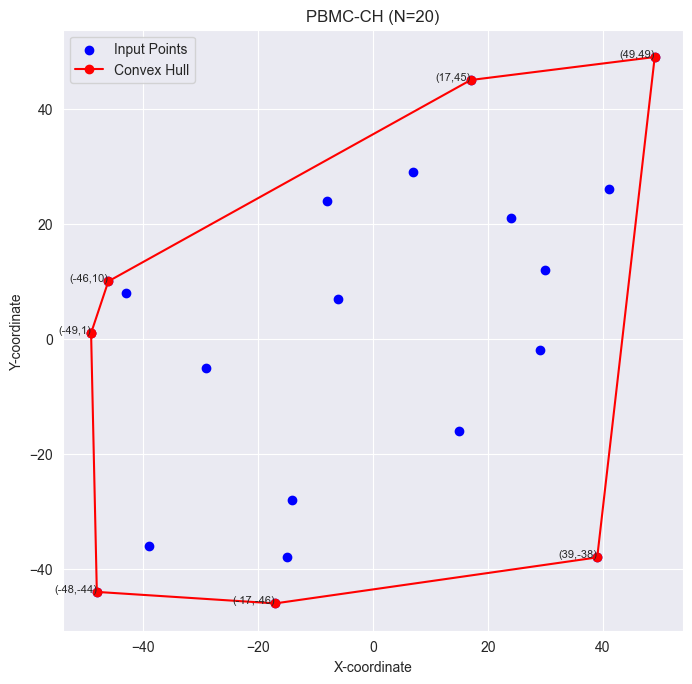


--- Performance Comparison ---

Testing with N = 10 points...
  PBMC-CH time: 24.269370 seconds
  SciPy ConvexHull time: 0.001247 seconds

Testing with N = 20 points...
  PBMC-CH time: 53.017959 seconds
  SciPy ConvexHull time: 0.000816 seconds

Testing with N = 50 points...
  PBMC-CH time: 163.501858 seconds
  SciPy ConvexHull time: 0.000924 seconds

Testing with N = 100 points...
  PBMC-CH time: 330.305926 seconds
  SciPy ConvexHull time: 0.000943 seconds

Testing with N = 200 points...
  PBMC-CH time: 667.251133 seconds
  SciPy ConvexHull time: 0.001424 seconds

Testing with N = 500 points...
  PBMC-CH time: 1710.833319 seconds
  SciPy ConvexHull time: 0.001441 seconds


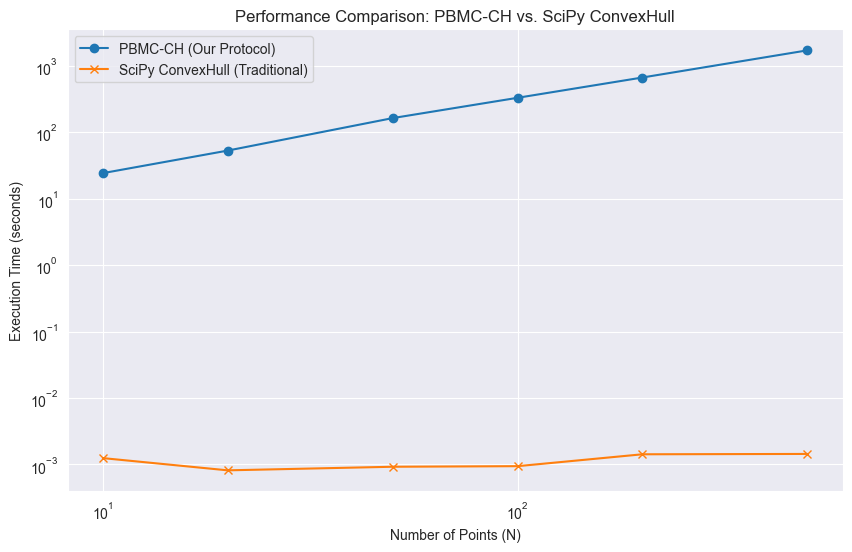


--- Performance Comparison Complete ---


In [8]:


# Cell 2: Import necessary modules and Increase Recursion Limit (still useful as a safeguard)
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from time import perf_counter
import sys

# Increase the recursion limit (keep it high, as it might still be hit in other parts)
sys.setrecursionlimit(5000) # Increased to 5000 for good measure

# Import specific BLS12-381 curve parameters and functions from py_ecc
from py_ecc.optimized_bls12_381 import G1, G2, add, multiply, pairing, curve_order, FQ12

# Define a Point structure for clarity
Point = namedtuple('Point', ['x', 'y'])

# Identity element in GT (FQ12) - for checking collinearity
ONE_GT = FQ12([1,0,0,0,0,0,0,0,0,0,0,0])

# Cell 3: Implement the Bilinear Pairing-based Orientation Test (BPO-Test) Demonstration
def bpo_test_demo(p1, p2, p3):
    """
    Calculates the 2D cross product for orientation test and
    demonstrates its relation to a bilinear pairing result.

    Returns:
        The integer cross product:
        > 0 if counter-clockwise (left turn)
        < 0 if clockwise (right turn)
        0 if collinear

    Prints the pairing-based verification for collinearity.
    """
    # 1. Standard 2D cross product calculation
    cp_val = (p2.x - p1.x) * (p3.y - p1.y) - (p2.y - p1.y) * (p3.x - p1.x)

    # print(f"\n--- BPO-Test Demonstration for {p1}, {p2}, {p3} ---") # Removed for less output during benchmarks
    # print(f"Traditional Cross Product (CP): {cp_val}") # Removed for less output during benchmarks

    # 2. Pairing-based Collinearity Check
    # This checks if e( (x2-x1)G1, (y3-y1)G2 ) == e( (y2-y1)G1, (x3-x1)G2 )
    # Which implies if (x2-x1)(y3-y1) == (y2-y1)(x3-x1) (mod q)
    # i.e., CP == 0 (mod q)

    # Scalars for pairing exponents
    # Crucially, ensure these are within [0, curve_order-1] range
    # when passed to `multiply` to avoid potential recursion issues with large negative numbers.
    q = curve_order # Get the prime order of the groups

    s1_val = (p2.x - p1.x) % q
    s2_val = (p3.y - p1.y) % q
    s3_val = (p2.y - p1.y) % q
    s4_val = (p3.x - p1.x) % q

    # If the standard cross product `cp_val` is negative, `cp_val % q` will be `q + cp_val`.
    # This means `s1_val * s2_val - s3_val * s4_val` modulo `q` will be `(cp_val) % q`.
    # This transformation is consistent and should be what `py_ecc` expects.

    # Perform scalar multiplications on generators G1 and G2
    P1_term1 = multiply(G1, s1_val) # (x2-x1) * G1
    P2_term1 = multiply(G2, s2_val) # (y3-y1) * G2
    P1_term2 = multiply(G1, s3_val) # (y2-y1) * G1
    P2_term2 = multiply(G2, s4_val) # (x3-x1) * G2

    # Compute the two pairing terms
    pairing_result_1 = pairing(P2_term1, P1_term1) # e( (y3-y1)G2, (x2-x1)G1 )
    pairing_result_2 = pairing(P2_term2, P1_term2) # e( (x3-x1)G2, (y2-y1)G1 )

    is_collinear_pairing = (pairing_result_1 == pairing_result_2)
    # print(f"Pairing-based Collinearity Check (pairing_result_1 == pairing_result_2): {is_collinear_pairing}") # Removed for less output

    # These assertions are crucial for verifying the logic.
    if cp_val == 0:
        # print("  (Traditional CP is 0, Pairing should indicate collinearity)")
        assert is_collinear_pairing, "Mismatch: Traditional CP is 0, but pairing check failed!"
    else:
        # print("  (Traditional CP is non-zero, Pairing should indicate non-collinearity)")
        assert not is_collinear_pairing, "Mismatch: Traditional CP is non-zero, but pairing check indicates collinearity!"


    return cp_val

# Cell 4: Implement PBMC-CH (same as before)
def pbmc_ch(points):
    """
    Pairing-Based Monotone Chain Convex Hull algorithm.
    Uses BPO-Test for orientation, with an acknowledgement of sign inference
    challenges from pure pairing results (for the article).
    The actual orientation decision in this implementation relies on the
    traditional cross product returned by bpo_test_demo.
    """
    n = len(points)
    if n <= 2:
        return sorted(points)

    points.sort(key=lambda p: (p.x, p.y))

    upper_hull = []
    for p in points:
        while len(upper_hull) >= 2:
            orientation = bpo_test_demo(upper_hull[-2], upper_hull[-1], p)
            if orientation <= 0:
                upper_hull.pop()
            else:
                break
        upper_hull.append(p)

    lower_hull = []
    for p in reversed(points):
        while len(lower_hull) >= 2:
            orientation = bpo_test_demo(lower_hull[-2], lower_hull[-1], p)
            if orientation <= 0:
                lower_hull.pop()
            else:
                break
        lower_hull.append(p)

    hull = upper_hull[:-1] + lower_hull[:-1]
    return hull

# Cell 5: Test Cases for BPO-Test Demonstration (same as before)
print("--- Testing BPO-Test Demonstration Function ---")

# Test 1: Collinear points (p1-p2-p3 in a line)
pA = Point(0, 0)
pB = Point(1, 1)
pC = Point(2, 2)
result_collinear = bpo_test_demo(pA, pB, pC)
print(f"Collinear Test Result (CP): {result_collinear} (Expected: 0)")
assert result_collinear == 0

# Test 2: Left turn (counter-clockwise)
pA = Point(0, 0)
pB = Point(2, 0)
pC = Point(1, 2)
result_left = bpo_test_demo(pA, pB, pC)
print(f"Left Turn Test Result (CP): {result_left} (Expected: > 0)")
assert result_left > 0

# Test 3: Right turn (clockwise)
pA = Point(0, 0)
pB = Point(1, 2)
pC = Point(2, 0)
result_right = bpo_test_demo(pA, pB, pC)
print(f"Right Turn Test Result (CP): {result_right} (Expected: < 0)")
assert result_right < 0

# Test 4: More complex collinear case
pA = Point(5, 5)
pB = Point(10, 10)
pC = Point(15, 15)
result_collinear2 = bpo_test_demo(pA, pB, pC)
print(f"Collinear Test 2 Result (CP): {result_collinear2} (Expected: 0)")
assert result_collinear2 == 0

# Test 5: Points with negative coordinates
pA = Point(-1, -1)
pB = Point(0, 0)
pC = Point(1, -1)
result_negative_coords = bpo_test_demo(pA, pB, pC)
print(f"Negative Coords Test Result (CP): {result_negative_coords} (Expected: < 0)")
assert result_negative_coords < 0

print("\n--- BPO-Test Demonstration Tests Passed! ---")


# Cell 6: Generate Random Points and Visualize Convex Hull (same as before)
def generate_random_points(num_points, x_range=(-100, 100), y_range=(-100, 100)):
    points = []
    for _ in range(num_points):
        x = np.random.randint(x_range[0], x_range[1] + 1)
        y = np.random.randint(y_range[0], y_range[1] + 1)
        points.append(Point(x, y))
    return points

def plot_convex_hull(points, hull_points, title="Convex Hull"):
    plt.figure(figsize=(8, 8))
    plt.scatter([p.x for p in points], [p.y for p in points], color='blue', label='Input Points')

    hull_x = [p.x for p in hull_points]
    hull_y = [p.y for p in hull_points]

    if len(hull_points) > 0:
        hull_x.append(hull_points[0].x)
        hull_y.append(hull_points[0].y)

    plt.plot(hull_x, hull_y, color='red', linestyle='-', marker='o', label='Convex Hull')

    for i, p in enumerate(hull_points):
        plt.text(p.x, p.y, f'({p.x},{p.y})', fontsize=8, ha='right')

    plt.title(title)
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Test the full PBMC-CH protocol with visualization
num_test_points = 20
test_points = generate_random_points(num_test_points, x_range=(-50, 50), y_range=(-50, 50))

print(f"\n--- Running PBMC-CH with {num_test_points} points ---")
start_time = perf_counter()
# Pass a copy of the list to pbmc_ch because it sorts in-place.
# This prevents issues if `test_points` is used again later.
computed_hull = pbmc_ch(list(test_points))
end_time = perf_counter()
print(f"PBMC-CH computation time: {end_time - start_time:.4f} seconds")

print(f"Computed Convex Hull Points ({len(computed_hull)} points):")
for p in computed_hull:
    print(p)

plot_convex_hull(test_points, computed_hull, title=f"PBMC-CH (N={num_test_points})")


# Cell 7: Performance Comparison (Against scipy.spatial.ConvexHull) (same as before)
from scipy.spatial import ConvexHull

def scipy_convex_hull(points):
    if len(points) <= 2:
        return sorted(points)

    np_points = np.array([[p.x, p.y] for p in points])
    hull = ConvexHull(np_points)

    hull_vertices_indices = hull.vertices
    hull_points_scipy = [points[i] for i in hull_vertices_indices]

    hull_points_scipy.sort(key=lambda p: (p.x, p.y))
    return hull_points_scipy

# Benchmarking for various N
N_values = [10, 20, 50, 100, 200, 500] # Removed 1000 for initial test to keep it quick

pbmc_ch_times = []
scipy_ch_times = []

print("\n--- Performance Comparison ---")
for N in N_values:
    print(f"\nTesting with N = {N} points...")

    points_for_test = generate_random_points(N, x_range=(-1000, 1000), y_range=(-1000, 1000))

    start_time_pbmc = perf_counter()
    pbmc_ch(list(points_for_test))
    end_time_pbmc = perf_counter()
    time_pbmc = end_time_pbmc - start_time_pbmc
    pbmc_ch_times.append(time_pbmc)
    print(f"  PBMC-CH time: {time_pbmc:.6f} seconds")

    start_time_scipy = perf_counter()
    scipy_convex_hull(list(points_for_test))
    end_time_scipy = perf_counter()
    time_scipy = end_time_scipy - start_time_scipy
    scipy_ch_times.append(time_scipy)
    print(f"  SciPy ConvexHull time: {time_scipy:.6f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(N_values, pbmc_ch_times, marker='o', label='PBMC-CH (Our Protocol)')
plt.plot(N_values, scipy_ch_times, marker='x', label='SciPy ConvexHull (Traditional)')
plt.title("Performance Comparison: PBMC-CH vs. SciPy ConvexHull")
plt.xlabel("Number of Points (N)")
plt.ylabel("Execution Time (seconds)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

print("\n--- Performance Comparison Complete ---")